## Q3.0 Linear Regression with Regularization [30 marks]

You will predict **GPA** using student features. Use a validation set to select the hyperparameters.  

Start with a function of the following form:  

```python
def run_poly_regression(
    X_train, y_train,
    X_val, y_val,
    X_test, y_test,
    degree=1,
    regularizer=None,
    reg_strength=0.0
):
    """
    Fit a polynomial regression model with optional regularization.
    
    Parameters:
        degree (int): Degree of the polynomial to fit
        regularizer (str or None): 'l1', 'l2', or None
        reg_strength (float): Regularization coefficient (alpha)
    
    Returns:
        dict with train, val, and test MSEs, and learned coefficients
    """


Tasks

For three setups – no regularization, L1, and L2 regularization – repeat the steps below: [8 × 3 = 24 marks]

Fit polynomial regression models across degrees 1 to 6. [2]

Plot polynomial degree vs MSE (on train and validation sets). Describe the trend you observe as degree increases. [3]

For each degree, use validation MSE to choose the best regularization strength. [1]

Plot regularization strength (log scale) vs validation MSE for the best degree. [2]

Comment on performance improvement (if any) from regularization. Which overall experimental setup (degree, regularizer) yielded the best test performance? [3]

For the best setup using L1 regularization, which features had non-zero weights?

List the most important predictors for GPA.

Repeat the same with L2 regularization.

Comment on the differences.

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder


In [9]:
USERNAME = "akshith.reddy"

def add_username_watermark():
    plt.text(
        0.95, 0.95, USERNAME,  # use global variable
        ha='right', va='top',
        transform=plt.gca().transAxes,
        fontsize=10,
        color='gray',
        alpha=0.7
    )


In [10]:


def run_poly_regression(X_train, y_train, X_val, y_val, X_test, y_test,
                        degree=1, regularizer=None, reg_strength=0.0):
    """
    Fit a polynomial regression model with optional regularization.

    Parameters:
        degree (int): Degree of the polynomial.
        regularizer (str or None): 'l1', 'l2', or None.
        reg_strength (float): Regularization coefficient (alpha).

    Returns:
        dict with train, val, test MSEs, and learned coefficients.
    """
    poly = PolynomialFeatures(degree=degree)
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)
    X_test_poly = poly.transform(X_test)

    scaler = StandardScaler()
    X_train_poly = scaler.fit_transform(X_train_poly)
    X_val_poly = scaler.transform(X_val_poly)
    X_test_poly = scaler.transform(X_test_poly)

    if regularizer is None:
        model = LinearRegression()
    elif regularizer == 'l1':
        model = Lasso(alpha=reg_strength, max_iter=5000)
    elif regularizer == 'l2':
        model = Ridge(alpha=reg_strength)
    else:
        raise ValueError("regularizer must be 'l1', 'l2', or None")

    model.fit(X_train_poly, y_train)

    y_train_pred = model.predict(X_train_poly)
    y_val_pred = model.predict(X_val_poly)
    y_test_pred = model.predict(X_test_poly)

    train_mse = mean_squared_error(y_train, y_train_pred)
    val_mse = mean_squared_error(y_val, y_val_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)

    return {
        "train_mse": train_mse,
        "val_mse": val_mse,
        "test_mse": test_mse,
        "coefficients": model.coef_,
        "intercept": model.intercept_,
        "features": poly.get_feature_names_out()
    }


def experiment_pipeline(X_train, y_train, X_val, y_val, X_test, y_test):
    degrees = range(1, 7) 
    reg_strengths = np.logspace(-3, 3, 10)  

    results = {"none": [], "l1": [], "l2": []}

    for d in degrees:
        res = run_poly_regression(X_train, y_train, X_val, y_val, X_test, y_test,
                                  degree=d, regularizer=None)
        results["none"].append(res)

    for reg in ["l1", "l2"]:
        for d in degrees:
            best_val_mse, best_model = float("inf"), None
            for alpha in reg_strengths:
                res = run_poly_regression(X_train, y_train, X_val, y_val, X_test, y_test,
                                          degree=d, regularizer=reg, reg_strength=alpha)
                if res["val_mse"] < best_val_mse:
                    best_val_mse, best_model = res["val_mse"], res
            results[reg].append(best_model)

    return results


def plot_degree_vs_mse(results, reg_type):
    degrees = range(1, 7)
    train_mse = [r["train_mse"] for r in results[reg_type]]
    val_mse = [r["val_mse"] for r in results[reg_type]]

    plt.plot(degrees, train_mse, label="Train MSE", marker="o")
    plt.plot(degrees, val_mse, label="Val MSE", marker="s")
    add_username_watermark()
    plt.xlabel("Polynomial Degree")
    plt.ylabel("MSE")
    plt.title(f"{reg_type.upper()} Regularization: Degree vs MSE")
    plt.legend()
    plt.show()


def plot_reg_strength_vs_mse(X_train, y_train, X_val, y_val,
                             degree, regularizer, reg_strengths):
    val_mse = []
    for alpha in reg_strengths:
        res = run_poly_regression(X_train, y_train, X_val, y_val, X_val, y_val,
                                  degree=degree, regularizer=regularizer, reg_strength=alpha)
        val_mse.append(res["val_mse"])

    plt.semilogx(reg_strengths, val_mse, marker="o")
    add_username_watermark()
    plt.xlabel("Regularization Strength (alpha)")
    plt.ylabel("Validation MSE")
    plt.title(f"{regularizer.upper()} Regularization (Degree={degree})")
    plt.show()


In [11]:
class PerFeatureTransformer:
    def __init__(self):
        self.transformers = {} 
        self.params = {}       

    def fit(self, df: pd.DataFrame, params: dict[str, str]) -> None:
        self.params = params
        for feat, t_type in params.items():
            col = df[[feat]]
            if t_type == "standard":
                scaler = StandardScaler().fit(col)
                self.transformers[feat] = scaler
            elif t_type == "onehot":
                enc = OneHotEncoder(sparse=False, handle_unknown="ignore").fit(col)
                self.transformers[feat] = enc
            elif t_type == "ordinal":
                if feat == "Major":
                    enc = OrdinalEncoder(categories=[["B.Tech", "MS", "PhD"]]).fit(col)
                else:
                    enc = OrdinalEncoder().fit(col)
                self.transformers[feat] = enc


    def transform(self, df: pd.DataFrame) -> np.ndarray:
        transformed = []
        for feat, t_type in self.params.items():
            col = df[[feat]]
            transformed.append(self.transformers[feat].transform(col))
        return np.hstack(transformed)

    def fit_transform(self, df: pd.DataFrame, params: dict[str, str]) -> np.ndarray:
        self.fit(df, params)
        return self.transform(df)


C:\Users\mavur_crvzl5q\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\mavur_crvzl5q\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


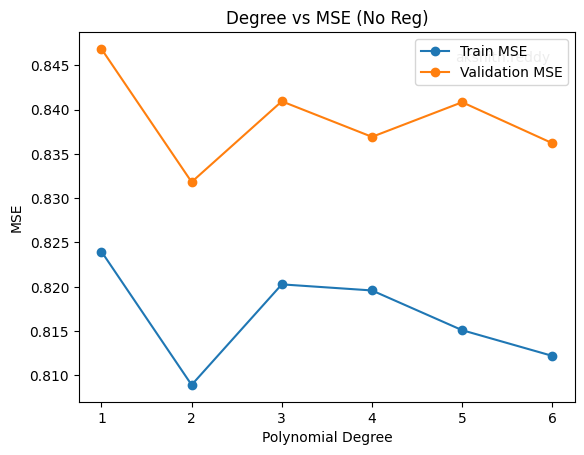

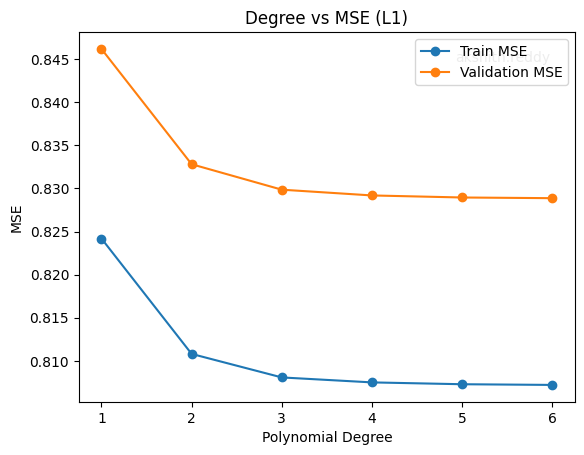

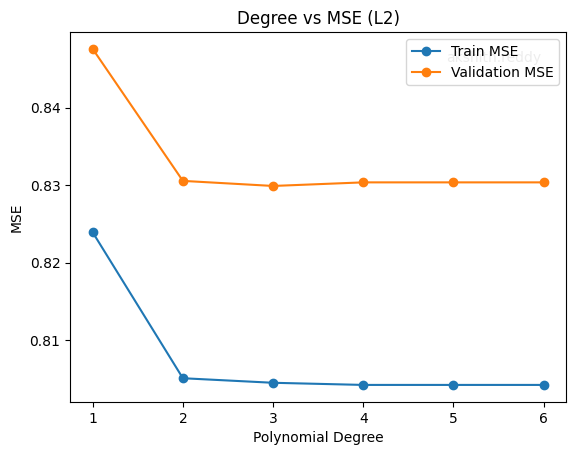

In [12]:
data = pd.read_csv("student_dataset.csv")  

params = {
    "Gender": "onehot",
    "Major": "ordinal",   # or "onehot"
    "Program": "onehot"
}

pft = PerFeatureTransformer()
X = pft.fit_transform(data, params)
y = data["GPA"].values


X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

degrees = range(1, 7)
reg_types = [None, "l1", "l2"]

all_results = []

for reg in reg_types:
    train_mses, val_mses = [], []
    for d in degrees:
        out = run_poly_regression(
            X_train, y_train,
            X_val, y_val,
            X_test, y_test,
            degree=d,
            regularizer=reg,
            reg_strength=0.01 if reg else 0.0
        )
        train_mses.append(out["train_mse"])
        val_mses.append(out["val_mse"])
        all_results.append({"regularizer": reg, "degree": d, **out})
    
    # plot degree vs mse
    plt.figure()
    add_username_watermark()
    plt.plot(degrees, train_mses, marker="o", label="Train MSE")
    plt.plot(degrees, val_mses, marker="o", label="Validation MSE")
    plt.xlabel("Polynomial Degree")
    plt.ylabel("MSE")
    plt.title(f"Degree vs MSE ({'No Reg' if reg is None else reg.upper()})")
    plt.legend()
    plt.show()


Best degree from validation: 6


C:\Users\mavur_crvzl5q\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.514e+00, tolerance: 6.396e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\mavur_crvzl5q\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.216e+00, tolerance: 6.396e-01
  model = cd_fast.enet_coordinate_descent(


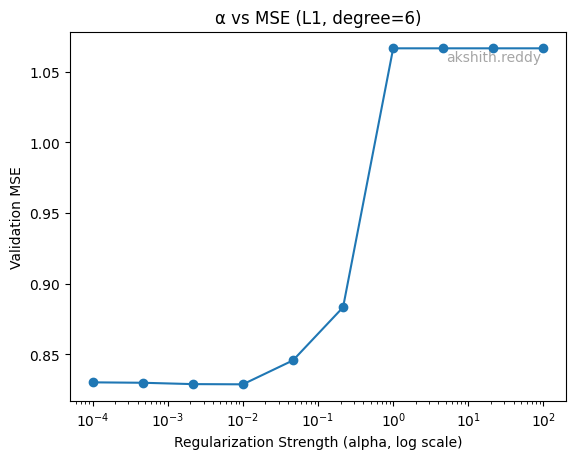

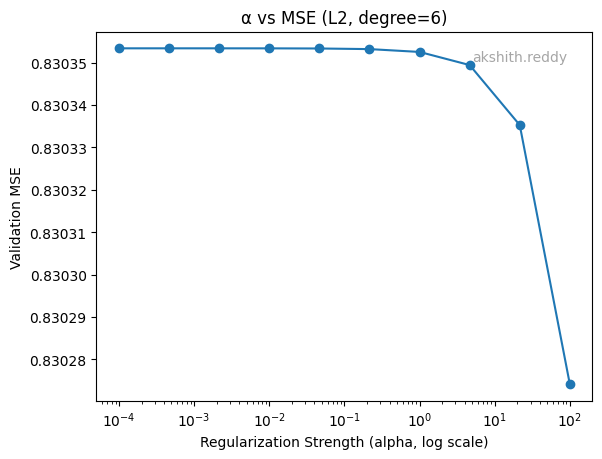

In [13]:
df = pd.DataFrame(all_results)
best_degree = df.loc[df["val_mse"].idxmin(), "degree"]
print("Best degree from validation:", best_degree)

strengths = np.logspace(-4, 2, 10)  # 0.0001 → 100
reg_strength_results = []

for reg in ["l1", "l2"]:
    val_mses = []
    for alpha in strengths:
        out = run_poly_regression(
            X_train, y_train,
            X_val, y_val,
            X_test, y_test,
            degree=best_degree,
            regularizer=reg,
            reg_strength=alpha
        )
        reg_strength_results.append({"regularizer": reg, "alpha": alpha, **out})
        val_mses.append(out["val_mse"])
    
    plt.figure()
    add_username_watermark()
    plt.semilogx(strengths, val_mses, marker="o")
    plt.xlabel("Regularization Strength (alpha, log scale)")
    plt.ylabel("Validation MSE")
    plt.title(f"α vs MSE ({reg.upper()}, degree={best_degree})")
    plt.show()


In [14]:
df_reg = pd.DataFrame(reg_strength_results)
best_setup = df_reg.loc[df_reg["val_mse"].idxmin()]
print("Best setup overall:", best_setup)


Best setup overall: regularizer                                                    l1
alpha                                                        0.01
train_mse                                                0.807208
val_mse                                                  0.828871
test_mse                                                  0.81662
coefficients    [0.0, 0.003535318565493053, -0.000827362073349...
intercept                                                 7.32408
features        [1, x0, x1, x2, x3, x4, x5, x6, x7, x0^2, x0 x...
Name: 3, dtype: object


In [15]:
# Best L1 model
df_l1 = df_reg[df_reg["regularizer"]=="l1"]
best_alpha_l1 = df_l1.loc[df_l1["val_mse"].idxmin(), "alpha"]
out_l1 = run_poly_regression(X_train, y_train, X_val, y_val, X_test, y_test,
                             degree=best_degree, regularizer="l1", reg_strength=best_alpha_l1)

print("Non-zero L1 features:", np.array(out_l1["features"])[out_l1["coefficients"]!=0])

# Best L2 model
df_l2 = df_reg[df_reg["regularizer"]=="l2"]
best_alpha_l2 = df_l2.loc[df_l2["val_mse"].idxmin(), "alpha"]
out_l2 = run_poly_regression(X_train, y_train, X_val, y_val, X_test, y_test,
                             degree=best_degree, regularizer="l2", reg_strength=best_alpha_l2)

coef_sorted_idx = np.argsort(np.abs(out_l2["coefficients"]))[::-1]
print("Top L2 features:", np.array(out_l2["features"])[coef_sorted_idx[:10]])



Non-zero L1 features: ['x0' 'x1' 'x3' 'x5' 'x0^2' 'x0 x5' 'x3 x4' 'x0^2 x5' 'x0 x5^2' 'x3 x4^2'
 'x0^3 x5' 'x0^2 x5^2' 'x0 x5^3' 'x3 x4^3' 'x0^4 x5' 'x0^3 x5^2'
 'x0^2 x5^3' 'x0 x5^4' 'x1^5' 'x3 x4^4' 'x0^6' 'x0^5 x5' 'x0^5 x7'
 'x0^4 x5^2' 'x0^4 x7^2' 'x0^3 x5^3' 'x0^3 x7^3' 'x0^2 x5^4' 'x0^2 x7^4'
 'x0 x3^4 x5' 'x0 x5^5' 'x0 x7^5' 'x1^6' 'x2^4 x3 x7' 'x3^6' 'x3^5 x5'
 'x3 x4^5' 'x5^6']
Top L2 features: ['x3' 'x1 x3' 'x1^4 x3' 'x1^5 x3' 'x1^3 x3' 'x1^2 x3' 'x3^6' 'x3^5'
 'x0^4 x3' 'x0^5 x3']
